In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import random
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D,BatchNormalization

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip real-and-fake-face-detection.zip -d /content/

 99% 429M/431M [00:01<00:00, 256MB/s]
100% 431M/431M [00:01<00:00, 233MB/s]
Archive:  real-and-fake-face-detection.zip
  inflating: /content/real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: /content/real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: /content/real_and_fake_face/training_fake/ea

In [ ]:
#renaming real and fake directories

real = "/content/real_and_fake_face_detection/real_and_fake_face/training_real"
fake = "/content/real_and_fake_face_detection/real_and_fake_face/training_fake"
#we're creating a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [ ]:
#creating training data with label for both genuine and fake images together
#we want to one hot encode our label such that it is in the following format
# [1] = genuine; 
# [0] = fake


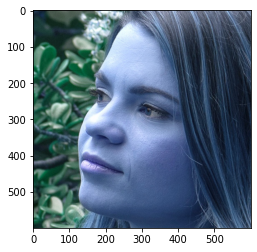

In [ ]:
plt.imshow(cv2.imread(os.path.join(real, real_path[0])))

In [ ]:
   
img_size = int(128)
def create_training_data():
    training_data = []
    y=[]
    for img in tqdm(real_path[:981]):
        path = os.path.join(real, img)
#         label = [1] 
        image = cv2.resize( cv2.imread(path), (img_size,img_size) )
        training_data.append(np.array(image))
        y.append(1)
        
    for img in tqdm(fake_path[:860]):
        path = os.path.join(fake, img)
#         label = [0] 
        image = cv2.resize(cv2.imread(path), (img_size,img_size))
        training_data.append(np.array(image))  
        y.append(0)
        
    return(training_data,y)

def create_test_data():
    test_data = []
    output_data=[]
    for img in tqdm(real_path[981:]):
        path = os.path.join(real, img)
        image = cv2.resize( cv2.imread(path), (img_size,img_size) )
        
        
        test_data.append(np.array(image))
        output_data.append(1)
        
    for img in tqdm(fake_path[860:]):
        path = os.path.join(fake, img)
        image = cv2.resize(cv2.imread(path), (img_size,img_size))
        
        test_data.append(np.array(image))
        output_data.append(0)

    return(test_data,output_data)

    

X_train,Y_train = create_training_data()
X_test,Y_test= create_test_data()

100%|██████████| 100/100 [00:01<00:00, 87.75it/s]


In [ ]:
l=list(zip(X_train,Y_train))
shuffle(l)
X_train,Y_train=zip(*l)

In [ ]:
# print(X[0].reshape(-1, 50, 50, 1))
X_train = np.array(X_train)

#divide by 255 to squish values to 0 - 1 normalization
X_train = X_train/255.0
Y_train=np.array(Y_train)


X_test = np.array(X_test)

#divide by 255 to squish values to 0 - 1 normalization
X_test = X_test/255.0
Y_test=np.array(Y_test)

In [ ]:
print(X_train.shape[1:])
print(X_train.shape[:])
#checking shape of array to confirm
# print(len(y))

(128, 128, 3)
(1841, 128, 128, 3)


In [ ]:
df=pd.DataFrame(Y_train)
df[0].value_counts()

1    981
0    860
Name: 0, dtype: int64

(128, 128, 3)

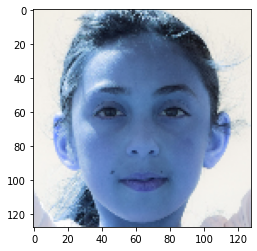

In [ ]:
plt.imshow(X_train[1])
X_train[1].shape

In [ ]:
#let us make the model

base = tf.keras.applications.xception.Xception(include_top=False,weights='imagenet',input_shape=X_train.shape[1:])
model = Sequential()
model.add(base)
# model.add(Conv2D(64,(3,3), input_shape=X_train.shape[1:])) 
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Activation("relu")) 

# model.add(Conv2D(32,(3,3)))  
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Activation("relu"))

# model.add(Conv2D(16,(3,3))) 
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Activation("relu"))



model.add(Flatten()) 

model.add(Dense(128,kernel_regularizer="l2"))
model.add(Activation("relu",))
model.add(Dropout(0.12))


model.add(Dense(1)) 
model.add(Activation("sigmoid"))


opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = "binary_crossentropy", optimizer =opt, metrics = ['accuracy'])

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

Epoch 1/25
26/26 [==============================] - 416s 16s/step - loss: 2.3972 - accuracy: 0.5320 - val_loss: 1.5085 - val_accuracy: 0.4919
Epoch 2/25
26/26 [==============================] - 410s 16s/step - loss: 1.1815 - accuracy: 0.6027 - val_loss: 1.4071 - val_accuracy: 0.6108
Epoch 3/25
26/26 [==============================] - 413s 16s/step - loss: 0.8166 - accuracy: 0.6624 - val_loss: 1.3496 - val_accuracy: 0.6270
Epoch 4/25
26/26 [==============================] - 414s 16s/step - loss: 0.6597 - accuracy: 0.7065 - val_loss: 1.2018 - val_accuracy: 0.6703
Epoch 5/25
26/26 [==============================] - 414s 16s/step - loss: 0.5727 - accuracy: 0.7579 - val_loss: 0.9067 - val_accuracy: 0.5946
Epoch 6/25
26/26 [==============================] - 413s 16s/step - loss: 0.5225 - accuracy: 0.7723 - val_loss: 1.1409 - val_accuracy: 0.6811
Epoch 7/25
26/26 [==============================] - 411s 16s/step - loss: 0.4765 - accuracy: 0.8086 - val_loss: 0.7957 - val_accuracy: 0.6703
Epoch 

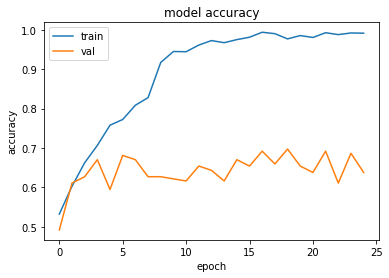

In [16]:
history = model.fit(X_train,Y_train, batch_size = 64, epochs = 25, validation_split = 0.1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 10s 1s/step - loss: 1.7140 - accuracy: 0.6150


[1.7139842510223389, 0.6150000095367432]

In [18]:
model.save('my_finalised_cnn', save_format='tf')

INFO:tensorflow:Assets written to: my_finalised_cnn/assets


In [ ]:
trained_model = keras.models.load_model('my_finalised_cnn') 
print (trained_model.summary())

In [ ]:

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model).create(prog="dot",format="svg"))

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
